In [1]:
# Importing packages

import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

In [2]:
# Importing and formatting iris data

names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Class Label']

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )

df.columns = names

df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Class Label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# Separate features and labels

features = df.drop('Class Label', axis=1)
classlabels = df['Class Label']

In [4]:
# Fit LDA from scikit-learn

sklearn_lda = lda(n_components=2)
sklearn_lda_features = sklearn_lda.fit_transform(features, classlabels)

In [5]:
# Plotting function

def plot_lda(two_lda_dimensions, label_matrix, title):
    
    # Make scatter plot, with labels and colors
    for label,marker,color in zip(
        ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),('^', 's', 'o'),('orange', 'black', 'grey')):

        plt.scatter(x=two_lda_dimensions[:,0][label_matrix == label],
                    y=two_lda_dimensions[:,1][label_matrix == label],
                    marker=marker,
                    color=color,
                    label=label)
    
    # Label axes
    plt.xlabel('Linear Discriminant 1')
    plt.ylabel('Linear Discriminant 2')
    
    # Add plot legend
    leg = plt.legend(loc='best', fancybox=True)
    
    # Add plot title
    plt.title(title)

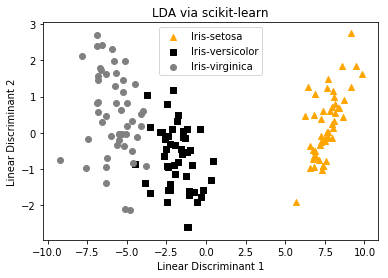

In [6]:
# Plot first two LDA dimensions from sklearn

plot_lda(two_lda_dimensions=sklearn_lda_features,
                 label_matrix=classlabels,
                 title='LDA via scikit-learn')

plt.show()

In [7]:
# Decision boundary plotting function

def plot_lda_decision_boundaries(two_lda_dimensions, label_matrix):
    
    # Create mesh_matrix, a mesh of points in space of first two linear discriminants
    ldone_min, ldone_max = two_lda_dimensions[:,0].min() - 1, two_lda_dimensions[:,0].max() + 1
    ldtwo_min, ldtwo_max = two_lda_dimensions[:,1].min() - 1, two_lda_dimensions[:,1].max() + 1

    ldoneone, ldtwotwo = np.meshgrid(np.linspace(ldone_min, ldone_max, 500),
                                 np.linspace(ldtwo_min, ldtwo_max, 500))

    mesh_matrix = np.c_[ldoneone.ravel(), ldtwotwo.ravel()]
    
    # Instantiate LDA model and fit LDA model on two_lda_dimensions
    lda_model = lda(n_components=2)
    lda_model.fit(two_lda_dimensions, label_matrix)
                                                                                   
    # Use LDA model to make categorical predictions on mesh_matrix
    mesh_predictions = lda_model.predict(mesh_matrix)
    
    # Map categorical predictions into numerical values for contour plotting
    speciesmap = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
    f = lambda x: speciesmap[x]
    fv = np.vectorize(f)
    Z = fv(mesh_predictions).reshape((len(ldoneone), len(ldtwotwo)))
    
    # Make contour plot
    plt.contourf(ldoneone, ldtwotwo, Z, levels=[-0.5,0.5,1.5,2.5], colors=('orange', 'black', 'grey'), alpha=0.4)

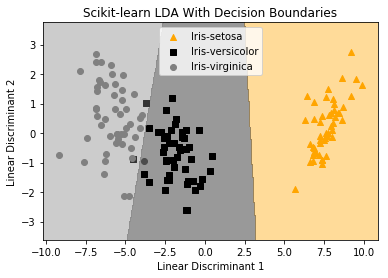

In [8]:
# Plot first two LDA dimensions along with decision boundaries

plot_lda(two_lda_dimensions=sklearn_lda_features,
        label_matrix=classlabels,
        title='Scikit-learn LDA With Decision Boundaries')

plot_lda_decision_boundaries(two_lda_dimensions=sklearn_lda_features,
                             label_matrix=classlabels)

plt.show()

In [9]:
# Implement LDA manually, Cell 1

# Compute the matrix of means of all features for each class label

species = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

mean_vector_matrix = [df.loc[df['Class Label'] == index].mean(numeric_only=True).values for index in species]
mean_vector_matrix = np.asarray(mean_vector_matrix).reshape(len(species), features.shape[1])

print mean_vector_matrix

# Also, compute global mean vector

global_mean_vector = df.mean(numeric_only=True).values

print global_mean_vector

[[5.006 3.418 1.464 0.244]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]
[5.84333333 3.054      3.75866667 1.19866667]


In [10]:
# Implement LDA manually, Cell 2

# Subtract within-class mean vector from each species instance to get mean corrected matrices

mean_corrected_setosa = df[df['Class Label'] == 'Iris-setosa'].drop('Class Label', axis=1) - mean_vector_matrix[0]
mean_corrected_versicolor = df[df['Class Label'] == 'Iris-versicolor'].drop('Class Label', axis=1) - mean_vector_matrix[1]
mean_corrected_virginica = df[df['Class Label'] == 'Iris-virginica'].drop('Class Label', axis=1) - mean_vector_matrix[2]

mean_corrected_setosa.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width
0,0.094,0.082,-0.064,-0.044
1,-0.106,-0.418,-0.064,-0.044
2,-0.306,-0.218,-0.164,-0.044
3,-0.406,-0.318,0.036,-0.044
4,-0.006,0.182,-0.064,-0.044


In [11]:
# Implement LDA manually, Cell 3

# Compute within-class scatter matrix, which is the sum of covariance matrices for each species
# Within-class scatter matrix is num_features x num_features dimensional, in this case 4x4

cov_setosa = np.matmul(mean_corrected_setosa.values.transpose(), mean_corrected_setosa.values)*(1.0/(len(mean_corrected_setosa) - 1))
cov_versicolor = np.matmul(mean_corrected_versicolor.values.transpose(), mean_corrected_versicolor.values)*(1.0/(len(mean_corrected_versicolor) - 1))
cov_virginica = np.matmul(mean_corrected_virginica.values.transpose(), mean_corrected_virginica.values)*(1.0/(len(mean_corrected_virginica) - 1))

within_class_scatter = (len(mean_corrected_setosa) - 1)*cov_setosa + (len(mean_corrected_versicolor) - 1)*cov_versicolor + (len(mean_corrected_virginica) - 1)*cov_virginica

print within_class_scatter

[[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [12]:
# Implement LDA manually, Cell 4

# Compute between-class scatter matrix, which is the sum over classes of covariances of mean_vector_matrix corrected for global_mean

cov_mean_setosa = np.matmul(np.array([mean_vector_matrix[0] - global_mean_vector]).transpose(), np.array([mean_vector_matrix[0] - global_mean_vector]))*len(mean_corrected_setosa)
cov_mean_versicolor = np.matmul(np.array([mean_vector_matrix[1] - global_mean_vector]).transpose(), np.array([mean_vector_matrix[1] - global_mean_vector]))*len(mean_corrected_versicolor)
cov_mean_virginica = np.matmul(np.array([mean_vector_matrix[2] - global_mean_vector]).transpose(), np.array([mean_vector_matrix[2] - global_mean_vector]))*len(mean_corrected_virginica)

between_class_scatter = cov_mean_setosa + cov_mean_versicolor + cov_mean_virginica

print between_class_scatter

[[ 63.21213333 -19.534      165.16466667  71.36306667]
 [-19.534       10.9776     -56.0552     -22.4924    ]
 [165.16466667 -56.0552     436.64373333 186.90813333]
 [ 71.36306667 -22.4924     186.90813333  80.60413333]]


In [13]:
# Implement LDA manually, Cell 5

# Maximize ratio of between-class to within-class scatter matrices by solving appropriate eigenvalue problem

eig_vals, eig_vecs = np.linalg.eig(np.matmul(np.linalg.inv(within_class_scatter), between_class_scatter))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))
    
# Sort eigenvalue, eigenvector pairs by decreasing eigenvalue
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)


Eigenvector 1: 
[[ 0.20490976]
 [ 0.38714331]
 [-0.54648218]
 [-0.71378517]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.00898234]
 [-0.58899857]
 [ 0.25428655]
 [-0.76703217]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.40368618]
 [-0.16629035]
 [-0.2398197 ]
 [ 0.86710524]]
Eigenvalue 3: -4.91e-15

Eigenvector 4: 
[[ 0.35279921]
 [-0.4263096 ]
 [-0.47966879]
 [ 0.68096307]]
Eigenvalue 4: 2.07e-15


In [14]:
# Implement LDA manually, Cell 6

# Choose first two linear discriminant dimensions and construct corresponding eigenvector matrix

n_dimensions = 2

eigen_matrix = np.array([eig_pairs[index][1] for index in range(n_dimensions)]).reshape(n_dimensions, len(eig_pairs[0][1])).transpose()

print eigen_matrix

[[ 0.20490976 -0.00898234]
 [ 0.38714331 -0.58899857]
 [-0.54648218  0.25428655]
 [-0.71378517 -0.76703217]]


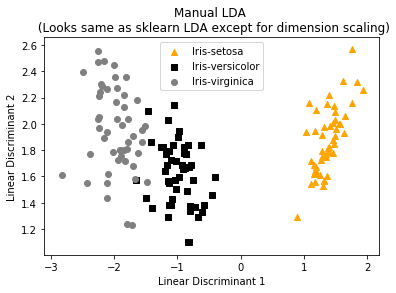

In [15]:
# Implement LDA manually, Cell 7

# Project features onto linear discriminant dimensions
# Different scales for linear discriminant dimensions because manual implementation is unstandardized

manual_lda_features = np.matmul(features, eigen_matrix)
manual_lda_features[:,1] *= -1.0 # eigenvalue problem invariant under constant scaling; done to match with sklearn implementation above

plot_lda(two_lda_dimensions=manual_lda_features,
                 label_matrix=classlabels,
                 title='Manual LDA \n (Looks same as sklearn LDA except for dimension scaling)')

plt.show()